In [1]:
import pandas as pd
import time
from dotenv import load_dotenv
load_dotenv("./.env.local")
import os
BEARER_TOKEN = os.getenv("BEARER_TOKEN")
# https://docs.tweepy.org/en/stable/client.html
import tweepy
client = tweepy.Client(BEARER_TOKEN, wait_on_rate_limit=True)
from pathlib import Path
import networkx as nx

# Data preprocessing

For each csv (one day = 1 csv) in the dataset folder:

    * filter to only keep english
    * only keep userid, tweetid, text, hashtags columns
    * delete duplicate based on test
    * sample 15k per day (for a total of around 200k for 2 weeks)
    * save the new df in the csvdataframes folder as day_{idx}.csv

In [2]:
# Preprocessing the datasets and save them in csv files under csvdataframes folder
Path.mkdir(Path("csvdataframes"), exist_ok=True)
Path.mkdir(Path("edgelists"), exist_ok=True)
Path.mkdir(Path("csvdataframes_wOgIds"), exist_ok=True)

In [4]:
for idx, day in enumerate(Path("dataset").iterdir()):
    full_dataset = pd.read_csv(day, compression='gzip')
    df_en = full_dataset[full_dataset['language']=='en']
    df_en_filteted = df_en[["userid", "tweetid", "text", "hashtags"]]
    df_no_duplicate = df_en_filteted.drop_duplicates(subset='text', keep='first')
    df_sampled = df_no_duplicate.sample(5)
    df_sampled.to_csv(Path(f"csvdataframes/day_{idx}.csv"))

C:\Users\Bao\AppData\Local\Temp\ipykernel_23768\3437197325.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  full_dataset = pd.read_csv(day, compression='gzip')


Because the original dataset contains retweet id, for each df in the
csvdataframes folder add a a new columns original_tweet_id with value the
original tweet id if the tweet was a retweet else keep the tweet id and save
every thing on the csvdataframes_wOgIds folder

In [5]:
def get_tweets(ids):
    tweets = client.get_tweets(ids=ids, expansions=['referenced_tweets.id', 'referenced_tweets.id.author_id'])
    return tweets

def get_original_tweets_ids(ids):
    # convert ids to list
    ids_list = ids["tweetid"].tolist()
    tweets = get_tweets(ids_list)
    # create df with columns original_tweet_id and author_id
    return_df = pd.DataFrame(columns=["author_id", "original_tweet_id"])
    if not tweets.data: return None, False
    for tweet in tweets.data:
        referenced_tweet = tweet.get('referenced_tweets')
        original_author = tweet.get('author_id')
        original_tweet_id = referenced_tweet[0].id if referenced_tweet else tweet.id
        # concat to df
        return_df = pd.concat([return_df, pd.DataFrame({"author_id": [original_author], "original_tweet_id": [original_tweet_id]})])
    return_df['Unnamed: 0'] = ids['Unnamed: 0']
    return return_df, True

In [6]:
for idx, file in enumerate(Path("csvdataframes").iterdir()):
    print(file)
    df = pd.read_csv(file)
    # temp df to store original tweet ids
    temp_df = pd.DataFrame()
    # split df by 100 
    for i in range(0, len(df), 100):
        print(f"{file} Iteration {i}-{i+100} / {len(df)}")
        df_100 = df[i:i+100]
        original_tweet_ids_df, empty_check = get_original_tweets_ids(df_100)
        if not empty_check: continue
        # concat temp_df and original_tweet_ids_df
        temp_df = pd.concat([temp_df, original_tweet_ids_df])
    # Merge temp_df with df
    if temp_df.empty: continue
    df = pd.merge(df, temp_df, on="Unnamed: 0")
    # save df to csv
    df.to_csv(Path(f"csvdataframes_wOgIds/day_{idx}.csv"), index=False)


csvdataframes\day_0.csv
csvdataframes\day_0.csv Iteration 0-100 / 5
csvdataframes\day_1.csv
csvdataframes\day_1.csv Iteration 0-100 / 5


# Edge list creation

In [6]:
# get_retweeters from 1 id and 1 pagination token
def get_retweeters(id, pagination_token=None):
    print(".", end='')
    retweeters = client.get_retweeters(id, pagination_token=pagination_token)
    next_token = retweeters.meta.get('next_token')

    if not retweeters.data:
        return None, None

    # return list of user ids
    retweeter_ids = [retweeter.id for retweeter in retweeters.data]
    return retweeter_ids, next_token

# get_all_retweeters from 1 id
def get_all_retweeters(id):
    retweeter_ids = []
    next_token = None
    while True:
        retweeter_ids_, next_token = get_retweeters(id, pagination_token=next_token)
        if retweeter_ids_ is None:
            break
        retweeter_ids += retweeter_ids_
    return retweeter_ids

In [5]:
def get_linkin_users(id, pagination_token=None):
    print(".", end='')
    retweeters = client.get_liking_users(id, pagination_token=pagination_token)
    next_token = retweeters.meta.get('next_token')

    if not retweeters.data:
        return None, None

    # return list of user ids
    retweeter_ids = [retweeter.id for retweeter in retweeters.data]
    return retweeter_ids, next_token

def get_all_linkin_users(id):
    retweeter_ids = []
    next_token = None
    while True:
        retweeter_ids_, next_token = get_linkin_users(id, pagination_token=next_token)
        if retweeter_ids_ is None:
            break
        retweeter_ids += retweeter_ids_
    return retweeter_ids

In [7]:
def create_retweeters_edgelist():
    # read csv files from csvdataframes_wOgIds folder
    for idx, file in enumerate(Path("csvdataframes_wOgIds").iterdir()):
        # create empty edgelists df with column retweeter_id and tweet_id
        edgelists_df = pd.DataFrame(columns=["retweeter_id", "author_id"])
        print(file)
        df = pd.read_csv(file)
        
        for tweetId, author_id in zip(df['original_tweet_id'], df['author_id']):
            print(tweetId, end='')
            retweeter_ids = get_all_retweeters(tweetId)
            # convert to df
            retweeter_ids_df = pd.DataFrame(retweeter_ids, columns=["retweeter_id"])
            # add tweetId to df
            retweeter_ids_df.insert(1, "author_id", author_id)
            # concat edgelists_df and retweeter_ids_df
            edgelists_df = pd.concat([edgelists_df, retweeter_ids_df])
            print("Done")
        # save df to csv
        edgelists_df.to_csv(Path(f"edgelists/retweeters_{idx}.csv"), index=False)

    # # save edgelists_df to csv
    # edgelists_df.to_csv(Path(f"edgelists/retweeters.csv"), index=False)

    # return edgelists_df

def create_liking_edgelist():
   

    # read csv files from csvdataframes_wOgIds folder
    for idx, file in enumerate(Path("csvdataframes_wOgIds").iterdir()):
         # create empty edgelists df with column liker_id and tweet_id
        edgelists_df = pd.DataFrame(columns=["liker_id", "author_id"])
        print(file)
        df = pd.read_csv(file)
        for tweetId, author_id in zip(df['original_tweet_id'], df['author_id']):
            print(tweetId, end='')
            liker_ids = get_all_linkin_users(tweetId)
            # convert to df
            liker_ids_df = pd.DataFrame(liker_ids, columns=["liker_id"])
            # add tweetId to df
            liker_ids_df.insert(1, "author_id", author_id)
            # concat edgelists_df and liker_ids_df
            edgelists_df = pd.concat([edgelists_df, liker_ids_df])
            print("Done")
        # save df to csv
        edgelists_df.to_csv(Path(f"edgelists/liking_{idx}.csv"), index=False)

    # # save edgelists_df to csv
    # edgelists_df.to_csv(Path(f"edgelists/liking.csv"), index=False)

    # return edgelists_df

In [8]:
create_retweeters_edgelist()
create_liking_edgelist()

csvdataframes_wOgIds\day_0.csv
1497907075187462144..Done
1498150851390885889.Done
csvdataframes_wOgIds\day_1.csv
1498328923343626245..Done
1498359286035935232..Done
csvdataframes_wOgIds\day_0.csv
1497907075187462144..Done
1498150851390885889.Done
csvdataframes_wOgIds\day_1.csv
1498328923343626245..Done
1498359286035935232..Done


In [11]:
edgelists_retweeters_df

,retweeter_id,author_id
0,144591936,916674562540167168
0,956009938895196160,216492959
1,1284530148033859586,216492959
2,879377928253050880,216492959
3,251009806,216492959
...,...,...
2157,1465037854489329681,456066153
2158,27999946,456066153
2159,974633309941784582,456066153
2160,288906657,456066153


In [12]:
edgelists_likers_df

,liker_id,author_id
0,1225817666990039040,916674562540167168
0,841062151691333634,216492959
1,1315716744,216492959
2,2717953176,216492959
3,1410654346648297482,216492959
...,...,...
5248,3689795193,456066153
5249,1496766645632704512,456066153
5250,2398023429,456066153
5251,815537014967832576,456066153


# First viz & basic stats

In [17]:
# load edgelists retweeters and liking from csv files to edgelists_df dataframe 
edgelists_retweeters_df = pd.read_csv(Path(f"edgelists/retweeters.csv"))
edgelists_likers_df = pd.read_csv(Path(f"edgelists/liking.csv"))

In [19]:
edgelists_likers_df

,liker_id,author_id
0,1225817666990039040,916674562540167168
1,841062151691333634,216492959
2,1315716744,216492959
3,2717953176,216492959
4,1410654346648297482,216492959
...,...,...
5754,3689795193,456066153
5755,1496766645632704512,456066153
5756,2398023429,456066153
5757,815537014967832576,456066153


In [31]:
# print number of unique users in edgelists_likers_df
print(len(edgelists_likers_df['liker_id'].unique()))

# print number of unique author in edgelists_likers_df
print(len(edgelists_likers_df['author_id'].unique()))

5753
8


In [32]:
# in edgelists_likers_df rename column liker_id to user_id
edgelists_likers_df.rename(columns={"liker_id": "user_id"}, inplace=True)

# in edgelists_retweeters_df rename column retweeter_id to user_id
edgelists_retweeters_df.rename(columns={"retweeter_id": "user_id"}, inplace=True)

# concat edgelists_likers_df and edgelists_retweeters_df
edgelists_df = pd.concat([edgelists_likers_df, edgelists_retweeters_df])

edgelists_df

,user_id,author_id
0,1225817666990039040,916674562540167168
1,841062151691333634,216492959
2,1315716744,216492959
3,2717953176,216492959
4,1410654346648297482,216492959
...,...,...
2291,1465037854489329681,456066153
2292,27999946,456066153
2293,974633309941784582,456066153
2294,288906657,456066153


In [33]:
# print number of unique users in edgelists_df
print(len(edgelists_df['user_id'].unique()))

# print number of unique author in edgelists_df
print(len(edgelists_df['author_id'].unique()))

6594
8


In [34]:
# drop duplicates in edgelists_df
edgelists_df.drop_duplicates(inplace=True)

edgelists_df

,user_id,author_id
0,1225817666990039040,916674562540167168
1,841062151691333634,216492959
2,1315716744,216492959
3,2717953176,216492959
4,1410654346648297482,216492959
...,...,...
2291,1465037854489329681,456066153
2292,27999946,456066153
2293,974633309941784582,456066153
2294,288906657,456066153


In [36]:
# load edgelists_df to networkx graph
edgelists_graph = nx.from_pandas_edgelist(edgelists_df, source='user_id', target='author_id')

# print number of nodes in edgelists_graph
print(len(edgelists_graph.nodes))

# print number of edges in edgelists_graph
print(len(edgelists_graph.edges))

6599
6602


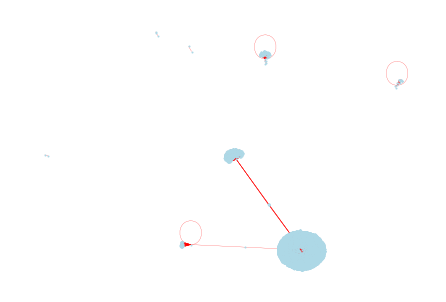

In [38]:
# draw edgelists_graph
# node color light blue
# edge color light blue
# node size proportional to degree
# edge width proportional to weight
# node labels hidden
# edge labels hidden
nx.draw(edgelists_graph, node_color='lightblue', edge_color='red', node_size=1, width=0.2, with_labels=False, labels={})

In [16]:
# load edgelists_retweeters_df and edgelists_likers_df to networkx
G_retweeters = nx.from_pandas_edgelist(edgelists_retweeters_df, source='author_id', target='retweeter_id')
G_likers = nx.from_pandas_edgelist(edgelists_likers_df, source='author_id', target='liker_id')

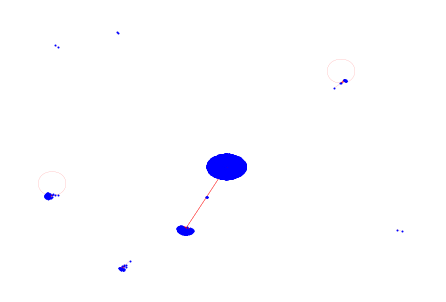

In [15]:
nx.draw(G_likers, with_labels=False, node_size=1, node_color='blue', edge_color='red', width=0.1)

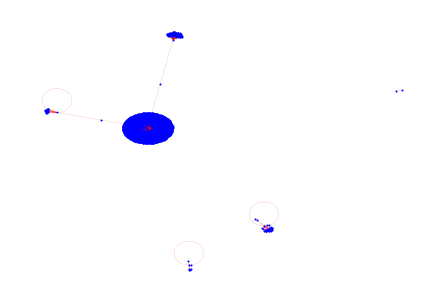

In [14]:
nx.draw(G_retweeters, with_labels=False, node_size=1, node_color='blue', edge_color='red', width=0.1)

In [20]:
# stats of retweeters network 
print(f"Number of nodes: {len(G_retweeters.nodes())}")
print(f"Number of edges: {len(G_retweeters.edges())}")

Number of nodes: 2297
Number of edges: 2296


In [21]:
# stats of likers network
print(f"Number of nodes: {len(G_likers.nodes())}")
print(f"Number of edges: {len(G_likers.edges())}")

Number of nodes: 5759
Number of edges: 5759


In [22]:
# clustering coefficient of retweeters network
print(f"Clustering coefficient: {nx.average_clustering(G_retweeters)}")

# clustering coefficient of likers network
print(f"Clustering coefficient: {nx.average_clustering(G_likers)}")

Clustering coefficient: 0.0
Clustering coefficient: 0.0


In [25]:
# average degree of retweeters network
print(f"Average degree: {nx.average_degree_connectivity(G_retweeters)}")

# average degree of likers network
print(f"Average degree: {nx.average_degree_connectivity(G_likers)}")

Average degree: {1: 2042.2126637554586, 73: 1.0136986301369864, 2: 1104.75, 8: 1.75, 33: 1.9393939393939394, 22: 1.9545454545454546, 2162: 1.0009250693802034}
Average degree: {1: 4820.3441196938065, 374: 1.0160427807486632, 2: 2813.5, 20: 1.9, 76: 1.9736842105263157, 35: 1.0, 5253: 1.0011422044545975}
